# Text Classification

Using neural networks, we will classify pieces of text according to the emotions they invoke. The dataset can be obtained [here](https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text). The data consists of two columns: the first column is the text, and the second column is a manually annotated emotion associated with each text. We will make models that take the text as input and predict what category of emotion that text should be associated with.

## Data Exploration

First, we'll read in the data.

In [73]:
import pandas as pd

df = pd.read_csv('data/Emotion_final.csv')
df.dropna() # drop rows with missing data
df['EmotionAsFactor'] = pd.factorize(df.Emotion)[0] # convert Emotion column to ints

We'll make a frequency graph of all the classes.

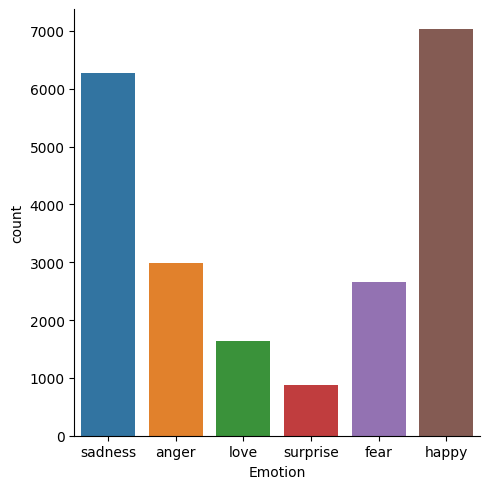

In [74]:
import seaborn as sb

sb.catplot(x='Emotion', kind='count', data=df[['Emotion']])

The data is slightly unbalanced in favor of happiness and sadness. Fortunately, the other categories are represented enough that any model cannot achieve an accuracy of over 70% by exclusively guessing those two categories.

## Model Training

First, we will divide the data into train and test sets. Every model we create will use the same label data, so we also go ahead and encode the target columns in both sets. The input data will have to be separately encoded depending on the type of model being created.

In [75]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# setting random seeds
tf.keras.utils.set_random_seed(1234)
np.random.seed(1234)

# train/test split
i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]

num_classes = df.EmotionAsFactor.nunique()
vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.Text)

# encode label column
encoder = LabelEncoder()
encoder.fit(train.EmotionAsFactor)
y_train = encoder.transform(train.EmotionAsFactor)
y_test = encoder.transform(test.EmotionAsFactor)

### Sequential Neural Network

We will make a dense sequential neural network and evaluate it on the test data. For this model, the input data is transformed to matrices according to the tf-idf frequency measure.

In [102]:
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

batch_size = 128
num_epochs = 30

# transform input
x_train = tokenizer.texts_to_matrix(train.Text, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test.Text, mode='tfidf')

# define model topology
model_seq = models.Sequential()
model_seq.add(layers.Dense(16, kernel_initializer='normal', activation='sigmoid'))
model_seq.add(layers.Dense(16, kernel_initializer='normal', activation='relu'))
model_seq.add(layers.Dense(num_classes, input_dim=vocab_size, kernel_initializer='normal', activation='softmax'))

# train
model_seq.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)

# apply to test data
model_seq.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_seq = model_seq.predict(x_test) # get predictions as label probabilities
pred_seq = np.argmax(pred_seq, axis=1) # get most likely label from probabilities

print('\naccuracy: ', accuracy_score(y_test, pred_seq))

Epoch 1/30
108/108 [==============================] - 3s 20ms/step - loss: 1.6612 - sparse_categorical_accuracy: 0.3303 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.2958
Epoch 2/30
108/108 [==============================] - 2s 16ms/step - loss: 1.5411 - sparse_categorical_accuracy: 0.3395 - val_loss: 1.5832 - val_sparse_categorical_accuracy: 0.2958
Epoch 3/30
108/108 [==============================] - 2s 16ms/step - loss: 1.4608 - sparse_categorical_accuracy: 0.3395 - val_loss: 1.5434 - val_sparse_categorical_accuracy: 0.2964
Epoch 4/30
108/108 [==============================] - 2s 16ms/step - loss: 1.3499 - sparse_categorical_accuracy: 0.3461 - val_loss: 1.4970 - val_sparse_categorical_accuracy: 0.3074
Epoch 5/30
108/108 [==============================] - 2s 16ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.4070 - val_loss: 1.4270 - val_sparse_categorical_accuracy: 0.4006
Epoch 6/30
108/108 [==============================] - 2s 15ms/step - loss: 1.0520 - sparse_cate

We get a fairly good accuracy of just over 80% with this simple network. This is fairly promising.

Also note that we used the softmax activation function in the last layer of the model, and the number of output nodes is equal to the number of classes. This has to be done to make the network topology compatible with multiclass classification, and the same will be done for all future models. For similar reasons, 'sparse_categorical_crossentropy' must be the loss function used during each model's compilation step.

### Convolutional Neural Network

We will now create a convolutional network and evaluate it. For this model, the inputs are transformed to sequences with an arbitrary maximum length of 500. The number of epochs has been reduced in the interest of training the model more quickly.

In [86]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500
batch_size = 128
num_epochs = 20

x_train = pad_sequences(tokenizer.texts_to_sequences(train.Text), maxlen=max_len)
x_test  = pad_sequences(tokenizer.texts_to_sequences(test.Text), maxlen=max_len)

model_cnn = models.Sequential()
model_cnn.add(layers.Embedding(vocab_size, 128, input_length=max_len)) 
model_cnn.add(layers.Conv1D(32, 7, activation='relu')) 
model_cnn.add(layers.MaxPooling1D(5)) 
model_cnn.add(layers.Conv1D(32, 7, activation='relu')) 
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(num_classes, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)
 
model_cnn.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_cnn = model_cnn.predict(x_test)
pred_cnn = np.argmax(pred_cnn, axis=1)

print('\naccuracy: ', accuracy_score(y_test, pred_cnn))

Epoch 1/20
108/108 [==============================] - 31s 260ms/step - loss: 1.5820 - sparse_categorical_accuracy: 0.3342 - val_loss: 1.6207 - val_sparse_categorical_accuracy: 0.3071
Epoch 2/20
108/108 [==============================] - 31s 287ms/step - loss: 1.5690 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.6353 - val_sparse_categorical_accuracy: 0.2958
Epoch 3/20
108/108 [==============================] - 34s 311ms/step - loss: 1.5508 - sparse_categorical_accuracy: 0.3613 - val_loss: 1.6015 - val_sparse_categorical_accuracy: 0.3493
Epoch 4/20
108/108 [==============================] - 34s 315ms/step - loss: 1.4283 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.4726 - val_sparse_categorical_accuracy: 0.4224
Epoch 5/20
108/108 [==============================] - 33s 304ms/step - loss: 1.1790 - sparse_categorical_accuracy: 0.5614 - val_loss: 1.3101 - val_sparse_categorical_accuracy: 0.5013
Epoch 6/20
108/108 [==============================] - 28s 262ms/step - loss: 0.9636 -

The accuracy of this CNN is unfortunately much lower than our original sequential network. The accuracy seems to have been increasing at a steady rate between all the epochs, so it is likely that more epochs or a greater batch size would result in a more accurate model.

### Embeddings

Now we will try different embedding schemes to try to improve our results. For these, we will not have to transform our existing sequence representations of the input data.

First, we'll try using pretrained embeddings from GloVe. Here we will use the 100 dimension embeddings.

In [81]:
embedding_dim = 100

embeddings_index = {}
with open('data/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [84]:
batch_size = 128
num_epochs = 20

model_em1 = models.Sequential()
model_em1.add(layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
))
model_em1.add(layers.Conv1D(128, 5, activation='relu'))
model_em1.add(layers.MaxPooling1D(5))
model_em1.add(layers.Conv1D(128, 5, activation='relu'))
model_em1.add(layers.MaxPooling1D(5))
model_em1.add(layers.GlobalMaxPooling1D())
model_em1.add(layers.Dropout(0.5))
model_em1.add(layers.Dense(128, activation="relu"))
model_em1.add(layers.Dense(num_classes, activation='softmax'))

model_em1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)
 
model_em1.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_em1 = model_em1.predict(x_test)
pred_em1 = np.argmax(pred_em1, axis=1)

print('\naccuracy: ', accuracy_score(y_test, pred_em1))

Epoch 1/20
108/108 [==============================] - 35s 313ms/step - loss: 1.5724 - sparse_categorical_accuracy: 0.3604 - val_loss: 1.5046 - val_sparse_categorical_accuracy: 0.4279
Epoch 2/20
108/108 [==============================] - 33s 305ms/step - loss: 1.3523 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.3443 - val_sparse_categorical_accuracy: 0.4836
Epoch 3/20
108/108 [==============================] - 39s 360ms/step - loss: 1.1245 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.2351 - val_sparse_categorical_accuracy: 0.5313
Epoch 4/20
108/108 [==============================] - 63s 584ms/step - loss: 0.9499 - sparse_categorical_accuracy: 0.6553 - val_loss: 1.0616 - val_sparse_categorical_accuracy: 0.6015
Epoch 5/20
108/108 [==============================] - 52s 481ms/step - loss: 0.8097 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1271 - val_sparse_categorical_accuracy: 0.5936
Epoch 6/20
108/108 [==============================] - 39s 364ms/step - loss: 0.7187 -

This model is a clear improvement over the first CNN. This can potentially be attributed to both the more complex network topology as well as the use of the pretrained embeddings from GloVe.

We will now see if using one of GloVe's higher dimension embeddings can improve our results. We will use the 300 dimension version.

In [87]:
embedding_dim = 300

embeddings_index = {}
with open('data/glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [88]:
batch_size = 128
num_epochs = 20

model_em2 = models.Sequential()
model_em2.add(layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
))
model_em2.add(layers.Conv1D(128, 5, activation='relu'))
model_em2.add(layers.MaxPooling1D(5))
model_em2.add(layers.Conv1D(128, 5, activation='relu'))
model_em2.add(layers.MaxPooling1D(5))
model_em2.add(layers.GlobalMaxPooling1D())
model_em2.add(layers.Dropout(0.5))
model_em2.add(layers.Dense(128, activation="relu"))
model_em2.add(layers.Dense(num_classes, activation='softmax'))

model_em2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)
 
model_em2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_em2 = model_em2.predict(x_test)
pred_em2 = np.argmax(pred_em2, axis=1)

print('\naccuracy: ', accuracy_score(y_test, pred_em2))

Epoch 1/20
108/108 [==============================] - 89s 800ms/step - loss: 1.5294 - sparse_categorical_accuracy: 0.3947 - val_loss: 1.3807 - val_sparse_categorical_accuracy: 0.4655
Epoch 2/20
108/108 [==============================] - 95s 878ms/step - loss: 1.1716 - sparse_categorical_accuracy: 0.5610 - val_loss: 1.1656 - val_sparse_categorical_accuracy: 0.5636
Epoch 3/20
108/108 [==============================] - 102s 941ms/step - loss: 0.8727 - sparse_categorical_accuracy: 0.6883 - val_loss: 1.0776 - val_sparse_categorical_accuracy: 0.6224
Epoch 4/20
108/108 [==============================] - 102s 945ms/step - loss: 0.6758 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.6594
Epoch 5/20
108/108 [==============================] - 92s 853ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.8576 - val_sparse_categorical_accuracy: 0.7112
Epoch 6/20
108/108 [==============================] - 84s 782ms/step - loss: 0.4466

The accuracy has slightly improved over the previous version. However, the accuracy is still less than that of the dense sequential model, indicating that the GloVe embeddings and/or CNNs are not very useful for this dataset.

We will now see if the GloVe embeddings can be used with a dense sequential network to get better results.

In [96]:
batch_size = 128
num_epochs = 30

model_em3 = models.Sequential()
model_em3.add(layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
))
model_em3.add(layers.GlobalMaxPooling1D())
model_em3.add(layers.Dense(32, kernel_initializer='normal', activation='relu'))
model_em3.add(layers.Dense(32, kernel_initializer='normal', activation='relu'))
model_em3.add(layers.Dense(num_classes, kernel_initializer='normal', activation='softmax'))

model_em3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)
 
model_em3.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_em3 = model_em3.predict(x_test)
pred_em3 = np.argmax(pred_em3, axis=1)

print('\naccuracy: ', accuracy_score(y_test, pred_em3))

Epoch 1/30
108/108 [==============================] - 8s 59ms/step - loss: 1.5869 - sparse_categorical_accuracy: 0.3439 - val_loss: 1.6135 - val_sparse_categorical_accuracy: 0.2958
Epoch 2/30
108/108 [==============================] - 6s 60ms/step - loss: 1.5552 - sparse_categorical_accuracy: 0.3788 - val_loss: 1.6155 - val_sparse_categorical_accuracy: 0.2993
Epoch 3/30
108/108 [==============================] - 7s 61ms/step - loss: 1.4894 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.5167 - val_sparse_categorical_accuracy: 0.3991
Epoch 4/30
108/108 [==============================] - 7s 68ms/step - loss: 1.4104 - sparse_categorical_accuracy: 0.4692 - val_loss: 1.5461 - val_sparse_categorical_accuracy: 0.3857
Epoch 5/30
108/108 [==============================] - 7s 68ms/step - loss: 1.3572 - sparse_categorical_accuracy: 0.4837 - val_loss: 1.4351 - val_sparse_categorical_accuracy: 0.4521
Epoch 6/30
108/108 [==============================] - 7s 67ms/step - loss: 1.3231 - sparse_cate

This model is unfortunately the worst so far. It suggests that using an embedding without a CNN or RNN does not really add value.

Now we will try to use vectorizations as a basis for our embeddings rather than tokenizations.

In [101]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_len = 200
batch_size = 128
num_epochs = 20
embedding_dim = 128

vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_len)
text_ds = tf.data.Dataset.from_tensor_slices(train.Text).batch(batch_size)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

x_train = vectorizer(np.array([[s] for s in train.Text])).numpy()
x_test = vectorizer(np.array([[s] for s in test.Text])).numpy()

model_em4 = models.Sequential()
model_em4.add(layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_len))
model_em4.add(layers.Conv1D(128, 5, activation='relu'))
model_em4.add(layers.MaxPooling1D(5))
model_em4.add(layers.Conv1D(128, 5, activation='relu'))
model_em4.add(layers.MaxPooling1D(5))
model_em4.add(layers.GlobalMaxPooling1D())
model_em4.add(layers.Dropout(0.5))
model_em4.add(layers.Dense(128, activation="relu"))
model_em4.add(layers.Dense(num_classes, activation='softmax'))

model_em4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['sparse_categorical_accuracy']
)
 
model_em4.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2
)

pred_em4 = model_em4.predict(x_test)
pred_em4 = np.argmax(pred_em4, axis=1)

print('\naccuracy: ', accuracy_score(y_test, pred_em4))

Epoch 1/20
108/108 [==============================] - 27s 227ms/step - loss: 1.5891 - sparse_categorical_accuracy: 0.3292 - val_loss: 1.6143 - val_sparse_categorical_accuracy: 0.3162
Epoch 2/20
108/108 [==============================] - 21s 196ms/step - loss: 1.4435 - sparse_categorical_accuracy: 0.3893 - val_loss: 1.2660 - val_sparse_categorical_accuracy: 0.4969
Epoch 3/20
108/108 [==============================] - 21s 197ms/step - loss: 0.8360 - sparse_categorical_accuracy: 0.6765 - val_loss: 1.0228 - val_sparse_categorical_accuracy: 0.5991
Epoch 4/20
108/108 [==============================] - 22s 206ms/step - loss: 0.4476 - sparse_categorical_accuracy: 0.8310 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7051
Epoch 5/20
108/108 [==============================] - 22s 201ms/step - loss: 0.2415 - sparse_categorical_accuracy: 0.9208 - val_loss: 0.8044 - val_sparse_categorical_accuracy: 0.7205
Epoch 6/20
108/108 [==============================] - 21s 198ms/step - loss: 0.1758 -

This model slightly outperformed our original model.

### Analysis

The best models were the dense sequential network and the last CNN, which utilized vectorizations of the input data. The sequential network likely outperformed most of the CNNs because looking for the presence or absence of words already gives a solid foundation for judging the sentiment of a text.

However, the CNNs may in general have been able to perform better if they were given more training time. For all but the last CNN tested, the increase in accuracy between epochs had yet to significantly plateau. Thus, it is likely that all the CNNs in this notebook are not performing at their most optimal level. The number of epochs was cut down in the interest of time, but it is clear that CNNs simply take a longer time to achieve better results.

Using pretrained embeddings definitely provides some value. Switching from the 100 dimension to 300 dimension versions of GloVe slightly improved performance, and as stated previously, all the CNNs may perform better if given more epochs to train. The true value of the GloVe embeddings may also be more apparent if RNNs were used on this dataset. However, RNNs were avoided simply because the training time is too long.